# Reconocimiento Facial (estilo CSI)

En este caso aplicaremos la técnica de SVM a un data set de rostros disponible a través de la librería `sklearn`.

El data set con el que trabajaremos queremos que contenga, al menos, 60 fotos por persona, por lo que le pasaremos este parámetro a la hora de definir el dataset.

Se trata, por supuesto, de un dataset etiquetado, ya que solo de esta manera podríamos aplicar la técnica de SVM de aprendizaje supervisado.

In [1]:
from sklearn.datasets import fetch_lfw_people

import matplotlib.pyplot as plt

In [2]:
faces = fetch_lfw_people(min_faces_per_person=60)

Accedemos al atributo `target_names` para conocer los nombres de las personas de las que nos hemos descargado las fotografías.

In [3]:
print(faces.target_names)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']


Ahora vemos que cantidad de datos nos hemos descargado.

In [4]:
print(faces.images.shape)

(1348, 62, 47)


Un total de:
* 1348 fotografías
* Todas las fotografías con una resolución de 62x47 pixeles

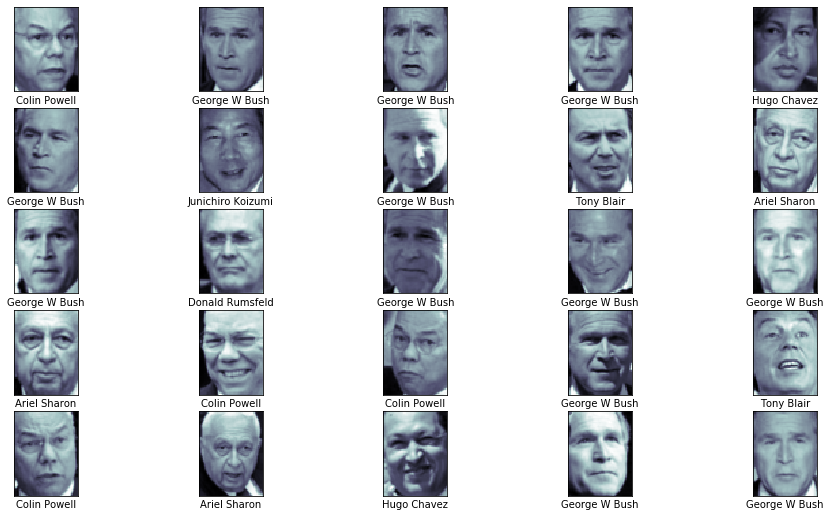

In [5]:
fig, ax = plt.subplots(5,5, figsize=(16,9))
for i, ax_i in enumerate(ax.flat):
    ax_i.imshow(faces.images[i], cmap='bone')
    ax_i.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

Como vimos, las fotografías tienen una resolución de 62x47 píxeles, es decir,

In [6]:
print("Las fotos contienen un total de ", 62*47, " píxeles.")

Las fotos contienen un total de  2914  píxeles.


Podríamos utilizar los valores de cada píxel de la imagen como rasgo a clasificar, pero esto significaría que estaríamos trabajando con un espacio vectorial de 2914 dimensiones. Por tanto, utilizar cada pixel como clasificador no resulta nada práctico.

En los problemas de clasificación de imágenes se utiliza un preprocesado que consiste en extraer los rasgos más importantes. 

Utilizaremos la técnica de `Análisis de Componentes Principales` para reducir las dimensiones extrayendo las componentes fundamentales y que nuestro SVM clasifique estas imágenes.

Además, cargaremos `make_pipeline` de la librería `sklearn`. Las `pipelines` son erramientas que utilizan los desarrolladores para ir encadenando instrucciones una tras otra.

Mi objetivo, como decíamos, es hacer una reducción de dimensiones seguido de una clasificación. Empleando un `pipeline` podremos hacer las dos tareas en una única modelización.

In [7]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

Para el PCA emplearemos los siguientes parámetros:
* `n_components`: la cantidad de componentes (dimensiones) a mantener
* `whiten`: Se establece como verdadero para que los vectores sean multiplicados por la raíz cuadrada del número de componentes `n_components` y luego dividida por los valores singulares para evitar correlaciones en el resultado basado en la varianza

Pasaremos a SVC:
* `rbf`como kernel del SVC ya que en imágenes parece más interesante que el modelo busque rasgos circulares que las clasifique
* `class_weight`: para que el clasificador pondere los rasgos que son más importantes

In [8]:
pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

Teniendo el modelo creado, podemos pasar a validación cruzado o separar el dataset en conjuntos de entrenamiento y validación.

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(faces.data, faces.target, random_state=42)

Emplearemos la validación cruzada como forma de buscar los hiperparámetros `C` y `gamma` de la `Radial Basis Function`, que controlan la dureza del margen y el tamaño de la función del radio.

Emplearemos la búsqueda en parrilla (`GridSearchCV`) de `sklearn` para combinar valores para ambos parámetros.

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:
param_grid = {
    "svc__C":[0.1,1,5,10,50],
    "svc__gamma": [0.0001,0.0005,0.001,0.005,0.01]
}
grid = GridSearchCV(model, param_grid, cv=3)

%time grid.fit(Xtrain,Ytrain)

/Users/carlosdavila/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CPU times: user 1min 2s, sys: 1.11 s, total: 1min 3s
Wall time: 36.8 s


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=150, random_state=42,
  svd_solver='auto', tol=0.0, whiten=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'svc__C': [0.1, 1, 5, 10, 50], 'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Una vez testeado el modelo, podemos obtener los mejores parámetros.

In [16]:
print(grid.best_params_)

{'svc__C': 10, 'svc__gamma': 0.001}


Una vez obtenidos los parámetros, si observamos que los mejores valores se acercan a los límites de la parrilla por uno u otro lado, tendremos que expandir la parrilla puesto que puede estar ocurriendo que los parámetros óptimos se encuentren fuera de ella.

Como en nuestro caso, nuestros parámetros se encuentran en entre los valores centrales de nuestra parrilla, procedemos a la validación del modelo con ellos.

In [17]:
classifier = grid.best_estimator_
yfit = classifier.predict(Xtest)

Y representamos algunos de los casos.

Text(0.5, 0.98, 'Predicciones de las imágenes (incorrectas en rojo)')

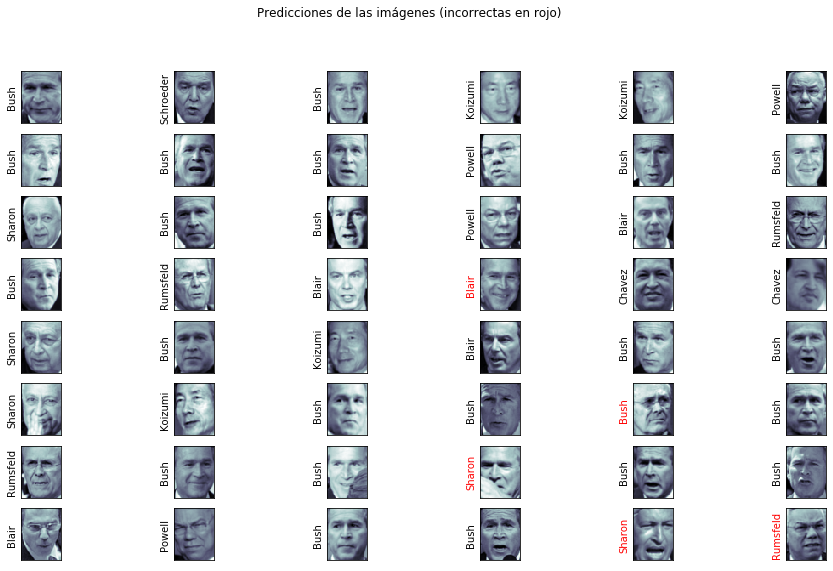

In [18]:
fig, ax = plt.subplots(8,6, figsize=(16,9))

for i, ax_i in enumerate(ax.flat):
    ax_i.imshow(Xtest[i].reshape(62,47), cmap='bone')
    ax_i.set(xticks=[], yticks=[])
    ax_i.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i]==Ytest[i] else 'red')
fig.suptitle("Predicciones de las imágenes (incorrectas en rojo)")

Vemos que nuestro estimador está teniendo un error de aproximadamente un 10% a la hora de clasificar las imagenes que le hemos proporcionado como conjunto de validación. 

Podemos comprobar la eficiencia de nuestro estimador con un reporte con el paquete `classification report`, que nos lista los estadísticos básicos de cada una de las clases que nosotros le suministremos.

In [19]:
from sklearn.metrics import classification_report

In [20]:
print(classification_report(Ytest, yfit, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

        micro avg       0.85      0.85      0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



Vemos entre los estadísticos que nos devuelve el reporte:
* `precision`: La precisión (especifidad) con la que clasifica a cada persona
* `recall`: La sensibilidad, que representa 1-falsos negativos, o las veces que no es catalogado como tal persona cuando no debe ser catalogado como tal persona
* `f1` el cociente de los dos primeros
* `support`: el número de individuos, o las veces que aparece cada uno

Otra manera de ver estos resultados es con una matriz de confusión. Primero la calculamos y luego la representamos con un mapa de calor.

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set

mat = confusion_matrix(Ytest, yfit)

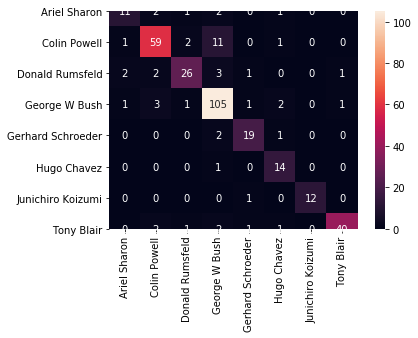

In [26]:
sns.heatmap(mat.T, square=True, annot=True, fmt='d',cbar=True,
            xticklabels=faces.target_names, yticklabels=faces.target_names)

En el diagrama vemos como el peor clasificado es Colin Powell, clasificado 11 veces como George Bush, mientras que el resto han sido mal clasificados 1, 2 ó 3 veces a lo sumo.

Normalmente, en los problemas de clasificación de caras con imágenes no se suele utilizar la ACP, sino otros algoritmos más sofisticados que extraen los rasgos reales de las caras y que esos rasgos sean independientes de la pixelación.

Para este tipo de problema existe una librería open source de SVM ya entrenadas que podemos incorporar a python: [OpenCV](https://opencv.org/). Cuenta con algoritmos capaces de detectar caras en imágenes a distintas resoluciones y tamaños de cara.